### RBR vs SBE CTD Comparison on DY1805

#### Cast 001
**Location: ** M2-ish

__Notes:__ Not a tremendous amount of gradients in this shallow cast.  Clock was not set appropriately so an offset had to be determined

In [43]:
%matplotlib inline

In [44]:
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [46]:
df_rbr = pd.read_excel('data/DY1805cast001.xlsx','Data',skiprows=[0],index_col='Time')
rbr_clock_offset = datetime.timedelta(seconds=(31557600*18 + 115*86400 +4 *3600 + 61))
df_rbr['DateTime']=[rbr_clock_offset + x for x,y in df_rbr.iterrows()]
df_rbr.set_index(df_rbr['DateTime'],inplace=True)

colnames = ['c0mS/cm','c1mS/cm','flECO-AFL','sbeox0V','sal00','sal11','t090C','t190C','timeS','prDM','sbeox1V','par','turbWETntu0','flag']
df_sbe = pd.read_csv('data/CTD001tm.cnv',skiprows=309,names=colnames,delimiter='\s+')

df_sbe['DateTime']=[datetime.datetime.strptime('Apr 30 2018 19:11:53','%b %d %Y %H:%M:%S')+datetime.timedelta(seconds=y['timeS']) for x,y in df_sbe.iterrows()]
df_sbe.set_index(df_sbe['DateTime'],inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'data/DY1805cast001.xlsx'

In [ ]:
fig1 = plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
df_sbe['t090C'].plot()
df_sbe['t190C'].plot()
df_rbr['Temperature'].plot()
#plt.xlim([datetime.datetime(2018,5,1,7,50),datetime.datetime(2018,5,1,8,15)])
plt.ylim([3.3,3.9])
ax=plt.gca()
ax.xaxis.set_major_formatter(DateFormatter(''))
plt.xlabel('')

plt.subplot(3,1,2)
df_sbe['sal00'].plot()
df_sbe['sal11'].plot()
df_rbr['Salinity'].plot()
#plt.xlim([datetime.datetime(2018,5,1,7,50),datetime.datetime(2018,5,1,8,15)])
plt.ylim([32.05,32.12])
ax=plt.gca()
ax.xaxis.set_major_formatter(DateFormatter(''))
plt.xlabel('')

plt.subplot(3,1,3)
df_sbe['prDM'].plot()
df_sbe['prDM'].plot()
df_rbr['Sea pressure'].plot()
#plt.xlim([datetime.datetime(2018,5,1,7,50),datetime.datetime(2018,5,1,8,15)])
ax=plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
plt.xlabel('')

For the above figure, Top plot is Temperature, Middle is Salinity, Bottom is Depth.  The RBR is plotted in Green and the two sbe sensors are plotted in blue/orange.  Both the temperature and depth visually look good.  The conductivity has a small (0.005) offset between the three instruments but more significant is the decay signal in the RBR at the onset.  

In [ ]:
fig1 = plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
df_sbe['t090C'].plot()
df_sbe['t190C'].plot()
df_rbr['Temperature.1'].plot()
#plt.xlim([datetime.datetime(2018,5,1,7,50),datetime.datetime(2018,5,1,8,15)])
plt.ylim([3,5.5])
ax=plt.gca()
ax.xaxis.set_major_formatter(DateFormatter(''))
plt.xlabel('')

plt.subplot(3,1,2)
df_sbe['c0mS/cm'].plot()
df_sbe['c1mS/cm'].plot()
df_rbr['Conductivity'].plot()
#plt.xlim([datetime.datetime(2018,5,1,7,50),datetime.datetime(2018,5,1,8,15)])
plt.ylim([29.6,29.9])
ax=plt.gca()
ax.xaxis.set_major_formatter(DateFormatter(''))
plt.xlabel('')

plt.subplot(3,1,3)
df_sbe['sal00'].plot()
df_sbe['sal11'].plot()
df_rbr['Salinity'].plot()
#plt.xlim([datetime.datetime(2018,5,1,7,50),datetime.datetime(2018,5,1,8,15)])
plt.ylim([32.05,32.12])
ax=plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
plt.xlabel('')

Exploring the sensors more explicitly, the secondary temperature probe (that is in the conductivity housing) is plotted over the actual temperature.  The conductivity is plotted in the middle plot and the salinity is again provided at the bottom.  Differences are very small in salinity but the decay signal does appear to be in the same region that the temperature of the conductivity cell is rapidly changing.  More analysis is needed

#### Cast 052
**Location: ** Unimak Box

__Notes:__ 
__Programming Notes:__ .rsk file is a SQLite3 file and it appears that all conductivity-temperature corrections are done prior to recording conductivity values.  Can read straight from file instead of converting with RBR software

__Processing Notes:__ .hex seabird files are converted to .cnv files and only the thermal correction (built in T/S offset) are performed.  .rsk files are not adjusted at all, but the salinity is calculated from the Temp/Cond/Press values as it is not in the raw data file.

In [47]:
import sqlite3
import seawater

In [48]:
data_file = 'data/DY1805cast052.rsk'
db = sqlite3.connect(data_file)

query = 'SELECT * FROM channels'
columns = pd.read_sql_query(query,db)

In [49]:
query = 'SELECT * FROM data'

df_r = pd.read_sql_query(query,db)

In [50]:
#time in rbr file is msec since 1970-1-1
import cftime #replaces import from netCDF4 date2num
df_r['cfdatetime'] = cftime.num2date(df_r['tstamp'],'milliseconds since 1970-1-1') - datetime.timedelta(hours=1) - datetime.timedelta(seconds=7)
df_r.set_index(df_r['cfdatetime'],inplace=True)

In [51]:
#Using TEOS-10 calculations for salinity from conductivity, temperature, pressure
df_r['conductivity'] = df_r.channel01
df_r['temperature'] = df_r.channel02
df_r['pressure'] = df_r.channel03 - 10.6 #subtract standard atmosphere

df_r['salinity'] = seawater.salt(r=df_r['conductivity']/42.914,t=df_r['temperature'],p=df_r['pressure'])

/Users/bell/anaconda2/envs/py36/lib/python3.6/site-packages/seawater/library.py:363: RuntimeWarning: invalid value encountered in sqrt
  Rtx = (rt) ** 0.5


In [52]:
colnames = ['c0mS/cm','c1mS/cm','flECO-AFL','sbeox0V','sal00','sal11','t090C','t190C','timeS','prDM','sbeox1V','par','turbWETntu0','flag']
df_sbe = pd.read_csv('data/CTD052tm.cnv',skiprows=309,names=colnames,delimiter='\s+')

#start_time
df_sbe['DateTime']=[datetime.datetime.strptime('May 10 2018 01:40:59','%b %d %Y %H:%M:%S')+datetime.timedelta(seconds=y['timeS']) for x,y in df_sbe.iterrows()]
df_sbe.set_index(df_sbe['DateTime'],inplace=True)

***There is an hour discrepency between the two instruments (RBR and SBE) - with the SBE being an hour behind the RBR.  CastLogs will clear this up definatively but it's likely the RBR was set an hour fast*** The correction is in the step above where the RBR time is converted.

Also there appears to be a seven second offset between the actual RBR time (minus the one hour error).

**Goal is to match up features in the profiles both in depth and in time**.  
Now - if you compare this to depth profiles below: there is a half meter difference in features.  This is not due to the clock, this is due to the removal of the weight of the atmosphere by assuming a standard atmsophere 10.1325.  I've pulled deck data from earlier in the timeseries to use as the atmsopheric pressure - 9.919 dBar - however, to compare to the SBE - one would need to know what atmospheric pressure they removed.  In this case the total ATM pressure correction to the RBR to match features is ~10.6 (based on just making manual adjustments).  ___RBR has a pressure corrected field in their output.  Should see how they determine the value___

Additional factor may be slight deviation in sighting/location of instrumentation (aka a small lag due to vertical differences although G.L. did his best to minimize this)

Text(0.5,0,'')

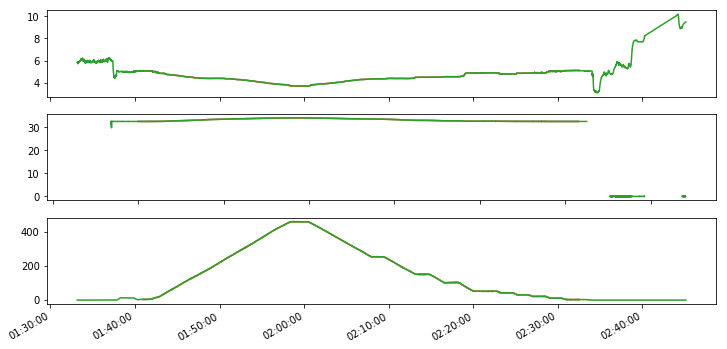

In [53]:
fig1 = plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
df_sbe['t090C'].plot()
df_sbe['t190C'].plot()
df_r['temperature'].plot()
#plt.xlim([datetime.datetime(2018,5,1,7,50),datetime.datetime(2018,5,1,8,15)])
#plt.ylim([3.3,3.9])
ax=plt.gca()
ax.xaxis.set_major_formatter(DateFormatter(''))
plt.xlabel('')

plt.subplot(3,1,2)
df_sbe['sal00'].plot()
df_sbe['sal11'].plot()
df_r['salinity'].plot()
#plt.xlim([datetime.datetime(2018,5,1,7,50),datetime.datetime(2018,5,1,8,15)])
#plt.ylim([32.05,32.12])
ax=plt.gca()
ax.xaxis.set_major_formatter(DateFormatter(''))
plt.xlabel('')

plt.subplot(3,1,3)
df_sbe['prDM'].plot()
df_sbe['prDM'].plot()
df_r['pressure'].plot()
#plt.xlim([datetime.datetime(2018,5,10,2,16,30),datetime.datetime(2018,5,10,2,16,50)])
#plt.ylim([100,110])
ax=plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
plt.xlabel('')

Text(0.5,0,'')

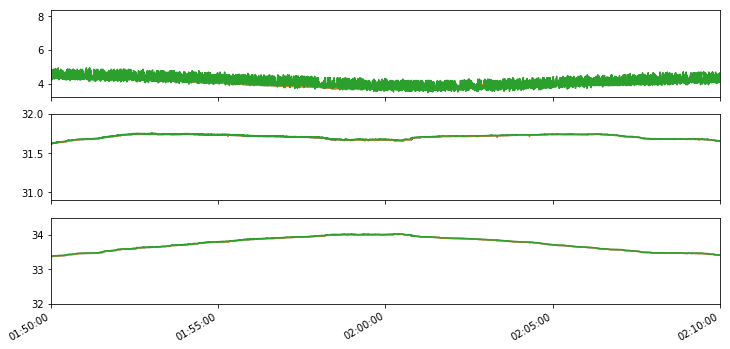

In [54]:
fig1 = plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
df_sbe['t090C'].plot()
df_sbe['t190C'].plot()
df_r['channel09'].plot()
plt.xlim([datetime.datetime(2018,5,10,1,50),datetime.datetime(2018,5,10,2,10)])
#plt.ylim([3,5.5])
ax=plt.gca()
ax.xaxis.set_major_formatter(DateFormatter(''))
plt.xlabel('')

plt.subplot(3,1,2)
df_sbe['c0mS/cm'].plot()
df_sbe['c1mS/cm'].plot()
df_r['conductivity'].plot()
plt.xlim([datetime.datetime(2018,5,10,1,50),datetime.datetime(2018,5,10,2,10)])
plt.ylim([30.9,32])
ax=plt.gca()
ax.xaxis.set_major_formatter(DateFormatter(''))
plt.xlabel('')

plt.subplot(3,1,3)
df_sbe['sal00'].plot()
df_sbe['sal11'].plot()
df_r['salinity'].plot()
plt.xlim([datetime.datetime(2018,5,10,1,50),datetime.datetime(2018,5,10,2,10)])
plt.ylim([32,34.5])
ax=plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
plt.xlabel('')

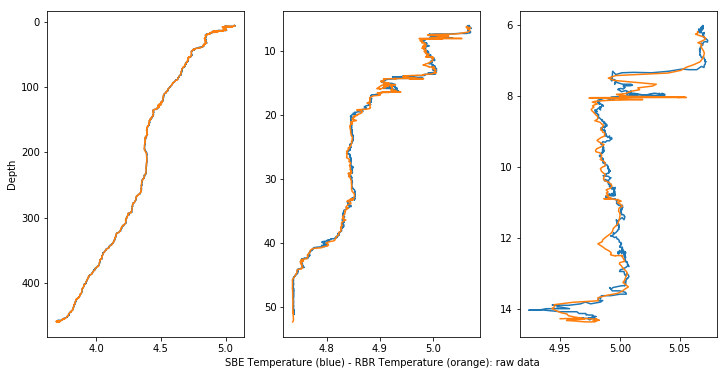

In [55]:
start_time = '2018-05-10 01:42:00'
end_time = '2018-05-10 02:00:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbe['t090C'][start_time:end_time],df_sbe['prDM'][start_time:end_time])
plt.plot(df_r['temperature'][start_time:end_time],df_r['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-05-10 01:44:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbe['t090C'][start_time:end_time],df_sbe['prDM'][start_time:end_time])
plt.plot(df_r['temperature'][start_time:end_time],df_r['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE Temperature (blue) - RBR Temperature (orange): raw data')

end_time = '2018-05-10 01:42:30'
ax =plt.subplot(1,3,3)
plt.plot(df_sbe['t090C'][start_time:end_time],df_sbe['prDM'][start_time:end_time])
plt.plot(df_r['temperature'][start_time:end_time],df_r['pressure'][start_time:end_time])
ax.invert_yaxis()

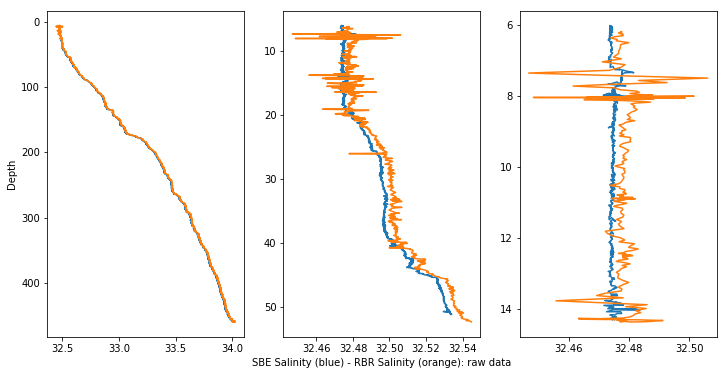

In [66]:
start_time = '2018-05-10 01:42:00'
end_time = '2018-05-10 02:00:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbe['sal00'][start_time:end_time],df_sbe['prDM'][start_time:end_time])
plt.plot(df_r['salinity'][start_time:end_time],df_r['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-05-10 01:44:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbe['sal00'][start_time:end_time],df_sbe['prDM'][start_time:end_time])
plt.plot(df_r['salinity'][start_time:end_time],df_r['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE Salinity (blue) - RBR Salinity (orange): raw data')

end_time = '2018-05-10 01:42:30'
ax =plt.subplot(1,3,3)
plt.plot(df_sbe['sal00'][start_time:end_time],df_sbe['prDM'][start_time:end_time])
plt.plot(df_r['salinity'][start_time:end_time],df_r['pressure'][start_time:end_time])
ax.invert_yaxis()

##### 1sec averages

Now lets sample to a comparable scale... 1s data will allow a direct comparison (although we usually use 1m/1dbar bins)

No additional qc has been done to the datasets

In [56]:
df_rsec = df_r.resample('1s').mean()
df_sbesec = df_sbe.resample('1s').mean()

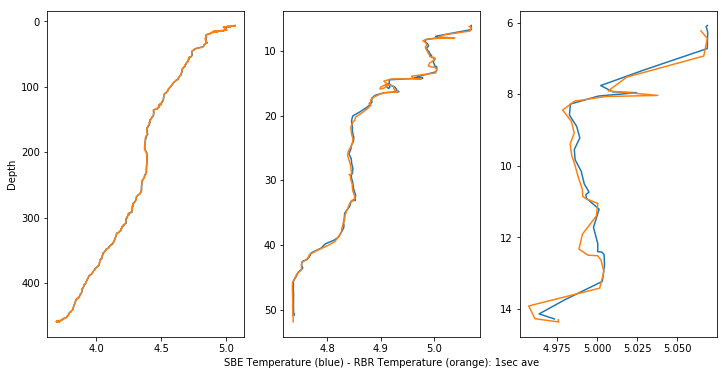

In [57]:
start_time = '2018-05-10 01:42:00'
end_time = '2018-05-10 02:00:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbesec['t090C'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['temperature'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-05-10 01:44:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbesec['t090C'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['temperature'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE Temperature (blue) - RBR Temperature (orange): 1sec ave')

end_time = '2018-05-10 01:42:30'
ax =plt.subplot(1,3,3)
plt.plot(df_sbesec['t090C'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['temperature'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()

In [58]:
##### 1sec averages - Difference between SBE-RBR


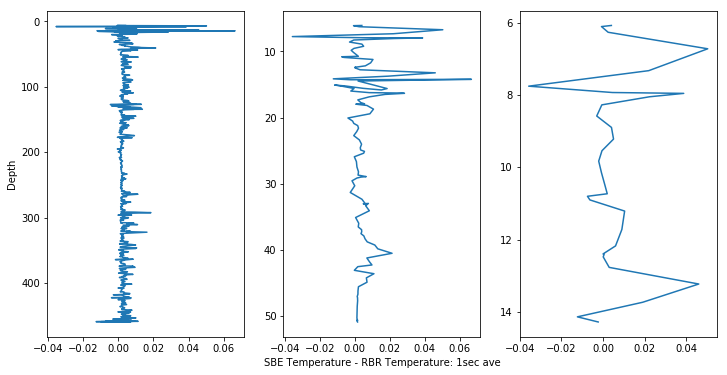

In [59]:
start_time = '2018-05-10 01:42:00'
end_time = '2018-05-10 02:00:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbesec['t090C'][start_time:end_time]-df_rsec['temperature'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-05-10 01:44:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbesec['t090C'][start_time:end_time]-df_rsec['temperature'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE Temperature - RBR Temperature: 1sec ave')

end_time = '2018-05-10 01:42:30'
ax =plt.subplot(1,3,3)
plt.plot(df_sbesec['t090C'][start_time:end_time]-df_rsec['temperature'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()

***salinity***

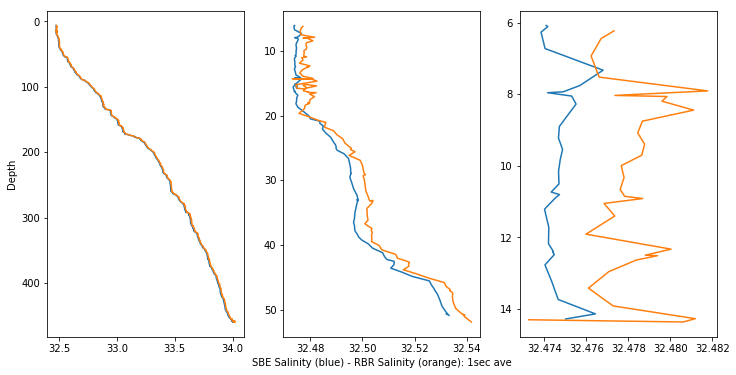

In [60]:
start_time = '2018-05-10 01:42:00'
end_time = '2018-05-10 02:00:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbesec['sal00'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['salinity'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-05-10 01:44:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbesec['sal00'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['salinity'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE Salinity (blue) - RBR Salinity (orange): 1sec ave')

end_time = '2018-05-10 01:42:30'
ax =plt.subplot(1,3,3)
plt.plot(df_sbesec['sal00'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['salinity'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()


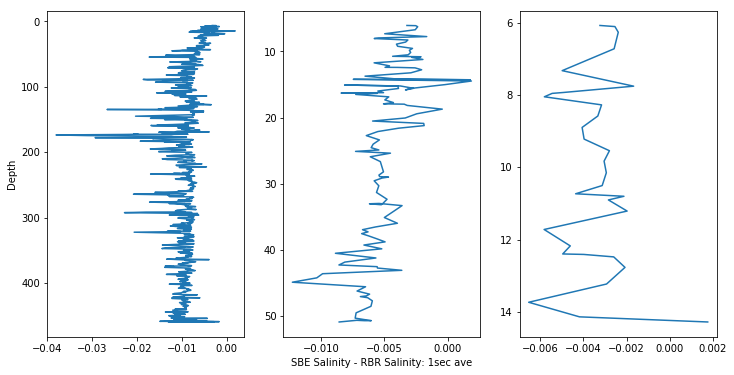

In [61]:
start_time = '2018-05-10 01:42:00'
end_time = '2018-05-10 02:00:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbesec['sal00'][start_time:end_time]-df_rsec['salinity'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-05-10 01:44:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbesec['sal00'][start_time:end_time]-df_rsec['salinity'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE Salinity - RBR Salinity: 1sec ave')

end_time = '2018-05-10 01:42:30'
ax =plt.subplot(1,3,3)
plt.plot(df_sbesec['sal00'][start_time:end_time]-df_rsec['salinity'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()

***sigma-t***

In [62]:
### calculate density (sigma-t) to compare against each other from the 1s data

import seawater

df_sbesec['sigmat00'] = seawater.dens(s=df_sbesec['sal00'],t=df_sbesec['t090C'],p=df_sbesec['prDM']) - 1000.
df_rsec['sigmat'] = seawater.dens(s=df_rsec['salinity'],t=df_rsec['temperature'],p=df_rsec['pressure']) - 1000.


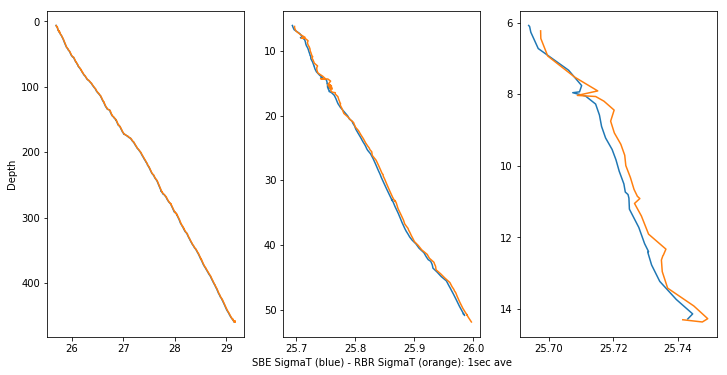

In [63]:
start_time = '2018-05-10 01:42:00'
end_time = '2018-05-10 02:00:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbesec['sigmat00'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['sigmat'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-05-10 01:44:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbesec['sigmat00'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['sigmat'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE SigmaT (blue) - RBR SigmaT (orange): 1sec ave')

end_time = '2018-05-10 01:42:30'
ax =plt.subplot(1,3,3)
plt.plot(df_sbesec['sigmat00'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['sigmat'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()


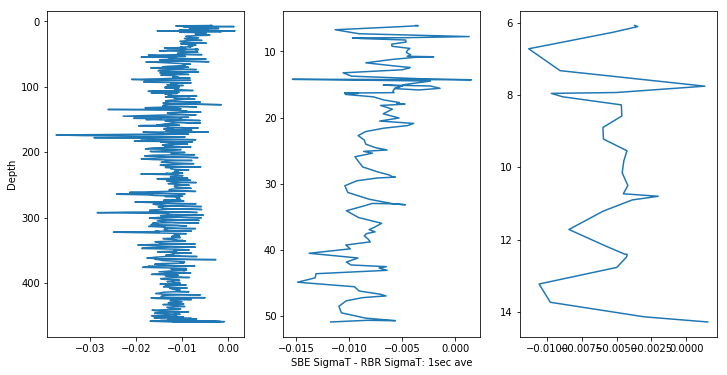

In [64]:
start_time = '2018-05-10 01:42:00'
end_time = '2018-05-10 02:00:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbesec['sigmat00'][start_time:end_time]-df_rsec['sigmat'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-05-10 01:44:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbesec['sigmat00'][start_time:end_time]-df_rsec['sigmat'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE SigmaT - RBR SigmaT: 1sec ave')

end_time = '2018-05-10 01:42:30'
ax =plt.subplot(1,3,3)
plt.plot(df_sbesec['sigmat00'][start_time:end_time]-df_rsec['sigmat'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()